<a href="https://colab.research.google.com/github/kcwc1029/obsidian-upgit-image/blob/main/extras/solutions/02_pytorch_classification_exercise_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercise Solutions

The following is one possible set (there may be more than one way to do things) of solutions for the 02. PyTorch WorkFlow Exercise template.

You can see a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ByyHwoEgF0Q).

See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [61]:
# DOC: 確認設備
import torch

# !nvidia-smi # Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"


class CFG:
  SEED = 42
  NUM_SAMPLES = 1000


device

'cuda'

<ipython-input-95-95d90f61c5fd>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(x, dtype=torch.float)


torch.Size([800, 2])

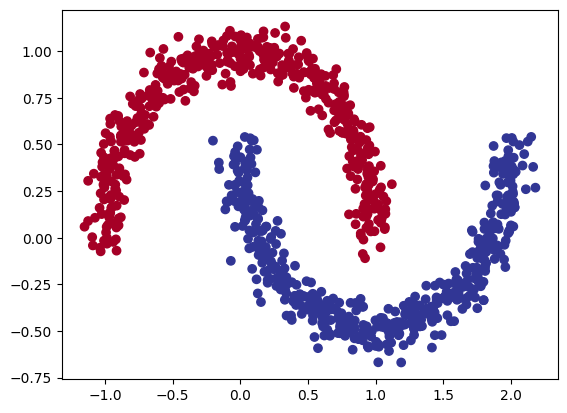

In [95]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

x, y = make_moons(n_samples=CFG.NUM_SAMPLES, noise=0.07, random_state=CFG.SEED)

# Visualize
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdYlBu);

# Turn data into tensors
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(x, dtype=torch.float)


# Split the data into train and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=CFG.SEED)
len(x_train), len(x_test), len(y_train), len(y_test)
y_train.shape

In [46]:
import torch
from torch import nn

class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()

        self.layer1 = nn.Linear(in_features=in_features,
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units,
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_0 = MoonModelV0(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model_0

MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [64]:
loss_fn = nn.BCEWithLogitsLoss() # sigmoid layer built-in
# loss_fn = nn.BCELoss() # requires sigmoid layer
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1) # learning rate


print("Logits:")
print(model_0(x_train.to(device)[:10]).squeeze())

# Prediction probabilities
print("Pred probs:")
print(torch.sigmoid(model_0(x_train.to(device)[:10]).squeeze()))

# Prediction probabilities
print("Pred labels:")
print(torch.round(torch.sigmoid(model_0(x_train.to(device)[:10]).squeeze())))

Logits:
tensor([0.0019, 0.0094, 0.0161, 0.0185, 0.0284, 0.0192, 0.0291, 0.0196, 0.0258,
        0.0079], device='cuda:0', grad_fn=<SqueezeBackward0>)
Pred probs:
tensor([0.5005, 0.5024, 0.5040, 0.5046, 0.5071, 0.5048, 0.5073, 0.5049, 0.5065,
        0.5020], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels:
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0',
       grad_fn=<RoundBackward0>)


In [51]:
# !pip -q install torchmetrics # colab doesn't come with torchmetrics

In [62]:
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [140]:
# !pip -q install torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

torch.manual_seed(CFG.SEED)
epochs=1000

# Send data to the device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)
print(y_train.shape)
# Loop through the data
for epoch in range(epochs):
  # Training
  model_0.train()
  # 1. Forward pass
  y_logits = model_0(x_train).squeeze()
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)
  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels
  # 3. Zero the gradients
  optimizer.zero_grad()
  # 4. Loss backward (perform backpropagation) - https://brilliant.org/wiki/backpropagation/#:~:text=Backpropagation%2C%20short%20for%20%22backward%20propagation,to%20the%20neural%20network's%20weights.
  loss.backward()
  # 5. Step the optimizer (gradient descent) - https://towardsdatascience.com/gradient-descent-algorithm-a-deep-dive-cf04e8115f21#:~:text=Gradient%20descent%20(GD)%20is%20an,e.g.%20in%20a%20linear%20regression)
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Caculate the loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test.int())

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

torch.Size([800])
Epoch: 0 | Loss: 0.01 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 100 | Loss: 0.01 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 200 | Loss: 0.01 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 300 | Loss: 0.01 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 400 | Loss: 0.01 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 500 | Loss: 0.01 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 600 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 700 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.00 Acc: 1.00 | Test loss: 0.00 Test acc: 1.00


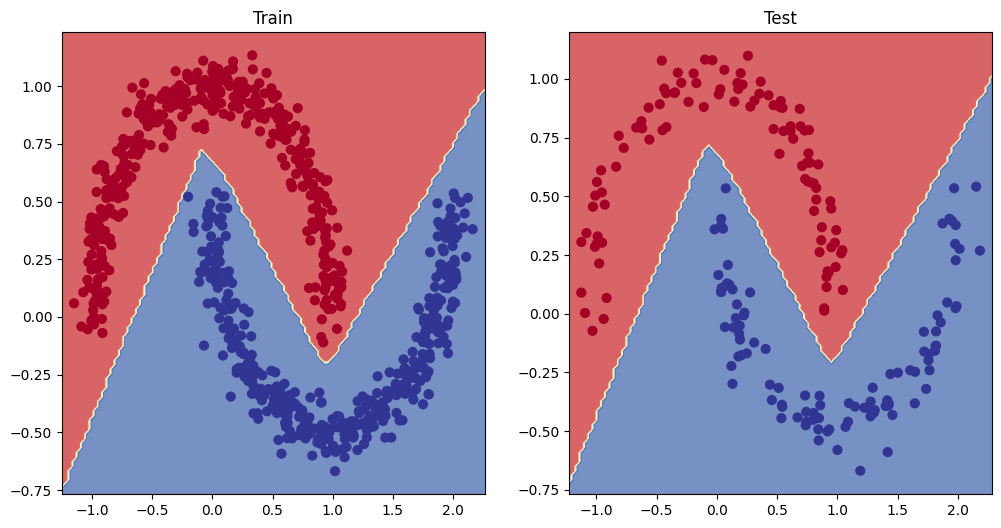

In [141]:
# Plot the model predictions
import numpy as np

# 作圖
def plot_decision_boundary(model, X, y):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))
    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)
    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary
    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# main
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, x_test, y_test)

# 下面是正解

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [ ]:
# Plot the model predictions
import numpy as np

# TK - this could go in the helper_functions.py and be explained there
def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

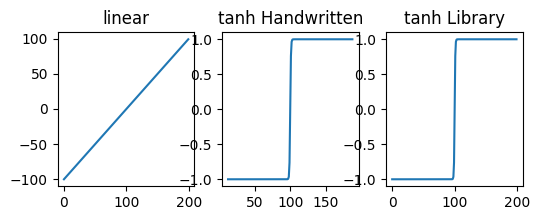

In [146]:
def tanh(x):
  # Source - https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))


tensor_A = torch.arange(-100, 100, 1)
plt.figure(figsize=(6, 2))
plt.subplot(1, 3, 1)
plt.title("linear")
plt.plot(tensor_A)
plt.subplot(1, 3, 2)
plt.title("tanh Handwritten")
plt.plot(tanh(tensor_A))
plt.subplot(1, 3, 3)
plt.title("tanh Library")
plt.plot(torch.tanh(tensor_A))

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

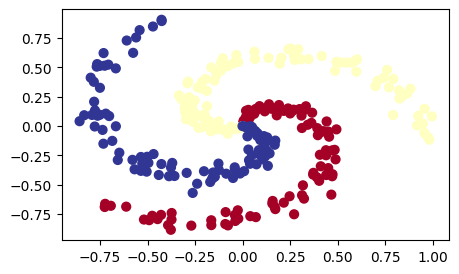

Epoch: 0 | Loss: 1.13 Acc: 0.32 | Test loss: 1.12 Test acc: 0.37
Epoch: 100 | Loss: 0.09 Acc: 0.98 | Test loss: 0.06 Test acc: 1.00
Epoch: 200 | Loss: 0.04 Acc: 0.99 | Test loss: 0.01 Test acc: 1.00
Epoch: 300 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 400 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 500 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 600 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 700 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 800 | Loss: 0.02 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00
Epoch: 900 | Loss: 0.01 Acc: 0.99 | Test loss: 0.00 Test acc: 1.00


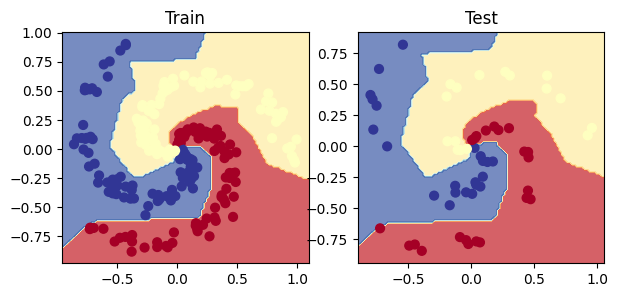

In [153]:
""" The program given in the question  """
# Code for creating a spiral dataset from CS231n
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.figure(figsize=(5, 3))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()



""" main code """
x = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long
device = "cuda" if torch.cuda.is_available() else "cpu"


# TODO: Calculation of precision rate
# !pip -q install torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device


# TODO: spilt data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=RANDOM_SEED)
len(x_train), len(x_test), len(y_train), len(y_test)
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)


# TODO: built model
import torch
from torch import nn
class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model = SpiralModel().to(device)


# TODO: Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.02)


# TODO: train loop
epochs = 1000
for epoch in range(epochs):
  ## Training
  model.train()
  # 1. forward pass
  y_logits = model(x_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)
  # 3. optimizer zero grad
  optimizer.zero_grad()
  # 4. loss backwards
  loss.backward()
  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model(x_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


# TODO: Visualize
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, x_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, x_test, y_test)

In [ ]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

In [ ]:
# Let's calculate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

In [ ]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(in_features=2, out_features=10)
    self.linear2 = nn.Linear(in_features=10, out_features=10)
    self.linear3 = nn.Linear(in_features=10, out_features=3)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))

model_1 = SpiralModel().to(device)
model_1

In [ ]:
# Setup data to be device agnostic
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
print(X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype)

# Print out untrained model outputs
print("Logits:")
print(model_1(X_train)[:10])

print("Pred probs:")
print(torch.softmax(model_1(X_train)[:10], dim=1))

print("Pred labels:")
print(torch.softmax(model_1(X_train)[:10], dim=1).argmax(dim=1))

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                             lr=0.02)

In [ ]:
# Build a training loop for the model
epochs = 1000

# Loop over data
for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1. forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step step step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)